In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('data.csv')

In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
columns_to_label_encode = ['NOMBRE_UNIDAD_EDUC', 'NOMBRE_COMUNA_EGRESO',
                            'PAGO_MATRICULA2020', 'PAGO_MENSUAL2020', 'PAGO_MATRICULA2021', 'PAGO_MENSUAL2021',
                            'PAGO_MATRICULA2022', 'PAGO_MENSUAL2022', 'PAGO_MATRICULA2023', 'PAGO_MENSUAL2023']

label_encoder = LabelEncoder()
for column in columns_to_label_encode:
    df.loc[:, column] = label_encoder.fit_transform(df.loc[:, column])

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [5]:
data = df_normalized.drop(['MRUN', 'CLEC_REG_ACTUAL', 'MATE1_REG_ACTUAL', 'MATE2_REG_ACTUAL', 'PROMEDIO_CM_MAX', ], axis=1).values
columns = df_normalized.drop(['MRUN', 'CLEC_REG_ACTUAL', 'MATE1_REG_ACTUAL', 'MATE2_REG_ACTUAL', 'PROMEDIO_CM_MAX', ], axis=1).columns
target = df_normalized['PROMEDIO_CM_MAX'].values

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

### Variación de hiperparámetros

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [50,100, 200],
    'min_samples_split': [2, 5, 10],
    'max_depth': [None, 10,20],
    'max_features': ['sqrt', 'log2', None],
    'oob_score': [True]
}
# Create a random forest regressor
rf = RandomForestRegressor()

# Perform grid search with cross-validation
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=3,verbose=3)
grid_search.fit(X_train[:5000], y_train[:5000])

# Get the best hyperparameters
best_params = grid_search.best_params_



Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV 1/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True;, score=0.465 total time=   0.6s
[CV 2/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True;, score=0.481 total time=   0.8s
[CV 3/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True;, score=0.491 total time=   0.8s
[CV 1/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True;, score=0.480 total time=   2.7s
[CV 2/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True;, score=0.490 total time=   2.1s
[CV 3/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True;, score=0.490 total time=   2.1s
[CV 1/3] E

In [7]:
# Train the model with the best hyperparameters
rf_best = RandomForestRegressor(**best_params)
rf_best.fit(X_train, y_train)

# Evaluate the model on the test set
predictions = rf_best.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Testing Mean Squared Error: {mse}')
mae = mean_absolute_error(y_test, predictions)
print(f'Testing Mean Absolute Error: {mae}')
r2 = r2_score(y_test, predictions)
print(f'Test R-squared: {r2}')
print(best_params)

Testing Mean Squared Error: 0.012074702695125245
Testing Mean Absolute Error: 0.08704371280409028
Test R-squared: 0.5279233476991139
{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'oob_score': True}


In [8]:
importance=np.array(rf_best.feature_importances_)

                 feature  importance
5         ANYO_DE_EGRESO    0.289100
7               PTJE_NEM    0.189764
6         PROMEDIO_NOTAS    0.142384
31      PAGO_MENSUAL2023    0.095008
17              EDAD_ALU    0.056155
3            DEPENDENCIA    0.052849
0               COD_SEXO    0.049447
1                    RBD    0.011372
9           PTJE_RANKING    0.009817
8         PORC_SUP_NOTAS    0.007532
2     NOMBRE_UNIDAD_EDUC    0.003551
4   NOMBRE_COMUNA_EGRESO    0.003102
30    PAGO_MATRICULA2023    0.002417
29      PAGO_MENSUAL2022    0.000242
26    PAGO_MATRICULA2021    0.000192
25      PAGO_MENSUAL2020    0.000142
15        ASISTENCIA2022    0.000136
27      PAGO_MENSUAL2021    0.000136
24    PAGO_MATRICULA2020    0.000121
28    PAGO_MATRICULA2022    0.000110
12         PROM_GRAL2021    0.000060
13        ASISTENCIA2021    0.000051
10         PROM_GRAL2020    0.000046
32                 RURAL    0.000040
23              MismaCom    0.000020
14         PROM_GRAL2022    0.000016
2

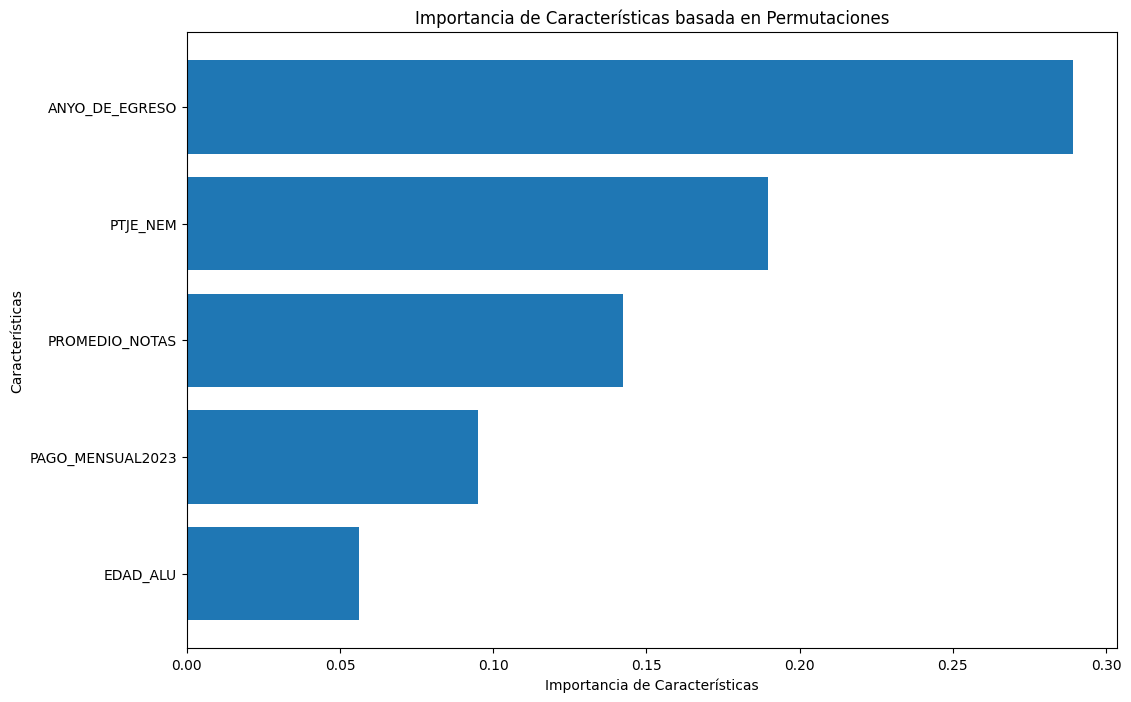

In [9]:
from sklearn.inspection import permutation_importance
# Calcular la importancia de las características
results = permutation_importance(rf_best, X_test, y_test, n_repeats=10, random_state=0)

# Obtener la media de la disminución en el score de las predicciones para cada característica
importances = results.importances_mean

# Crear un DataFrame para visualizar mejor la importancia de cada característica
feature_importances = pd.DataFrame({'feature': columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Mostrar las características más importantes
print(feature_importances)

# Visualizar la importancia de las características
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['feature'][:5], feature_importances['importance'][:5])
plt.xlabel('Importancia de Características')
plt.ylabel('Características')
plt.title('Importancia de Características basada en Permutaciones')
plt.gca().invert_yaxis()
plt.show()

C:\Users\benja\AppData\Local\Temp\ipykernel_24772\2635636841.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


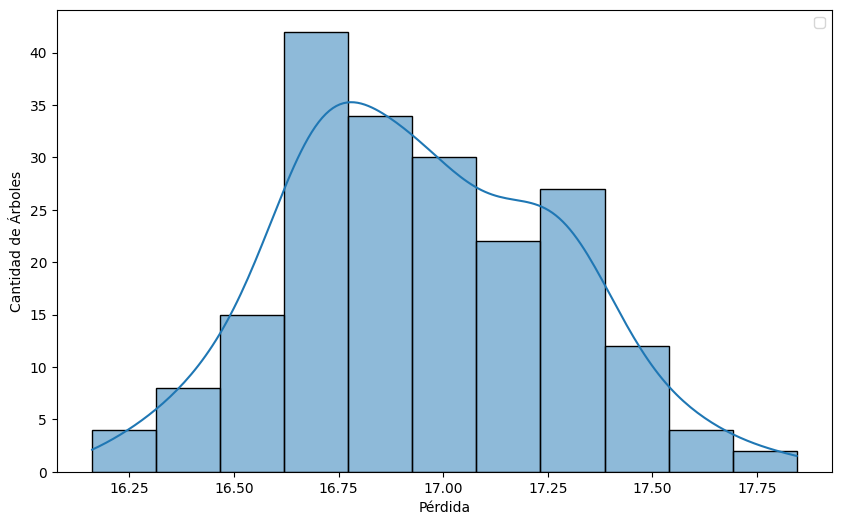

In [20]:
# Plot the training and validation loss for rf_best
import seaborn as sns
loss_train = []
loss_val = []
for i in range(len(rf_best.estimators_)):
    loss_train.append(rf_best.estimators_[i].tree_.impurity.sum())

plt.figure(figsize=(10, 6))
sns.histplot(loss_train,kde=True)
plt.xlabel('Pérdida')

plt.ylabel('Cantidad de Árboles')
plt.legend()
plt.show()


In [ ]:
# prompt: create a dict between columns and importance, ordering on a descendent value of importance

feature_importances = dict(zip(columns, importance))
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
print(sorted_features)


[('PROMEDIO_NOTAS', 0.33719550649184726), ('PTJE_NEM', 0.17410116524549388), ('ANYO_DE_EGRESO', 0.1640474506645723), ('PAGO_MENSUAL2023', 0.1370666556172671), ('COD_SEXO', 0.04370396206316207), ('EDAD_ALU', 0.03460544888673205), ('DEPENDENCIA', 0.020927434046646574), ('RBD', 0.01977967161405683), ('PTJE_RANKING', 0.01310446370095517), ('NOMBRE_UNIDAD_EDUC', 0.00981634705268726), ('NOMBRE_COMUNA_EGRESO', 0.007534838430177751), ('PORC_SUP_NOTAS', 0.005847759912782663), ('PAGO_MATRICULA2023', 0.004452961777153817), ('ASISTENCIA2022', 0.0025081409359607345), ('ASISTENCIA2023', 0.0025066382766725354), ('PROM_GRAL2021', 0.002469031772636554), ('PROM_GRAL2020', 0.002458723991358527), ('COD_COM_RBD', 0.00231718634618123), ('COD_COM_ALU2023', 0.0022668537879899594), ('PROM_GRAL2023', 0.002166653530593046), ('PROM_GRAL2022', 0.002061621201592876), ('ASISTENCIA2021', 0.0017196191926370599), ('ASISTENCIA2020', 0.0011883748708427634), ('PAGO_MENSUAL2022', 0.0011068006536834308), ('PAGO_MENSUAL2020'

In [ ]:
for a in range(len(columns)):
    print(f'{columns[a]}: {importance[a]:.3f}')

COD_SEXO: 0.044
RBD: 0.020
NOMBRE_UNIDAD_EDUC: 0.010
DEPENDENCIA: 0.021
NOMBRE_COMUNA_EGRESO: 0.008
ANYO_DE_EGRESO: 0.164
PROMEDIO_NOTAS: 0.337
PTJE_NEM: 0.174
PORC_SUP_NOTAS: 0.006
PTJE_RANKING: 0.013
PROM_GRAL2020: 0.002
ASISTENCIA2020: 0.001
PROM_GRAL2021: 0.002
ASISTENCIA2021: 0.002
PROM_GRAL2022: 0.002
ASISTENCIA2022: 0.003
GEN_ALU2023: 0.000
EDAD_ALU: 0.035
COD_COM_ALU2023: 0.002
PROM_GRAL2023: 0.002
ASISTENCIA2023: 0.003
COD_JOR: 0.000
COD_COM_RBD: 0.002
MismaCom: 0.000
PAGO_MATRICULA2020: 0.001
PAGO_MENSUAL2020: 0.001
PAGO_MATRICULA2021: 0.001
PAGO_MENSUAL2021: 0.001
PAGO_MATRICULA2022: 0.001
PAGO_MENSUAL2022: 0.001
PAGO_MATRICULA2023: 0.004
PAGO_MENSUAL2023: 0.137
RURAL: 0.000
